# **(Hypothetical) Rently - London Market**

## Contents


1. Introduction 
2. Sourcing and Loading
3. Cleaning, Transforming, and Visualizing
4. Modeling
5. Saving File
6. Summary












## 1. Introduction

Here’s the problem we’re going to solve for Rently: 

> **Using historical sales data, from the London housing market, which five boroughs of London have seen the greatest increase in housing prices, on average, over the last two decades?**

NOTE: *A borough is just a fancy word for district. You may be familiar with the five boroughs of New York… well, there are 32 boroughs within Greater London [(here's some info for the curious)](https://en.wikipedia.org/wiki/London_boroughs).

## 2. Sourcing and Loading 

### 2.1. Importing libraries

In [1]:
#Import necessary libaries and rename 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

### 2.2.  Loading data
The data used comes from the [London Datastore](https://data.london.gov.uk/): a free, open-source data-sharing portal for London-oriented datasets. 

In [2]:
#Assign URL link to a vaiable
url_LondonHousePrices = "https://data.london.gov.uk/download/uk-house-price-index/70ac0766-8902-4eb5-aab5-01951aaed773/UK%20House%20price%20index.xls"

#The dataset we're interested in contains the Average prices of the houses, and is actually on a particular sheet of the Excel file. 
#As a result, we need to specify the sheet name in the read_excel() method.
#We will put this data into a variable called properties.  
properties = pd.read_excel(url_LondonHousePrices, sheet_name='Average price', index_col= None)

## 3. Cleaning, Transforming, and Visualizing


### 3.1. Exploring the data

In [3]:
properties.shape

(322, 49)

The shape indicates that there are 49 columns. However, there are only 32 boroughs in London and we want to include the City of London as well. Therefore, 49 columns suggests there are some columns in the dataframe that are not boroughs or the City of London. Let's explore the data further to understand why.

In [4]:
properties.head()

,Unnamed: 0,City of London,Barking & Dagenham,Barnet,Bexley,Brent,Bromley,Camden,Croydon,Ealing,Enfield,Greenwich,Hackney,Hammersmith & Fulham,Haringey,Harrow,Havering,Hillingdon,Hounslow,Islington,Kensington & Chelsea,Kingston upon Thames,Lambeth,Lewisham,Merton,Newham,Redbridge,Richmond upon Thames,Southwark,Sutton,Tower Hamlets,Waltham Forest,Wandsworth,Westminster,Unnamed: 34,Inner London,Outer London,Unnamed: 37,NORTH EAST,NORTH WEST,YORKS & THE HUMBER,EAST MIDLANDS,WEST MIDLANDS,EAST OF ENGLAND,LONDON,SOUTH EAST,SOUTH WEST,Unnamed: 47,England
0,NaT,E09000001,E09000002,E09000003,E09000004,E09000005,E09000006,E09000007,E09000008,E09000009,E09000010,E09000011,E09000012,E09000013,E09000014,E09000015,E09000016,E09000017,E09000018,E09000019,E09000020,E09000021,E09000022,E09000023,E09000024,E09000025,E09000026,E09000027,E09000028,E09000029,E09000030,E09000031,E09000032,E09000033,NaN,E13000001,E13000002,NaN,E12000001,E12000002,E12000003,E12000004,E12000005,E12000006,E12000007,E12000008,E12000009,NaN,E92000001
1,1995-01-01,91449,50460.2,93284.5,64958.1,71306.6,81671.5,120933,69158.2,79885.9,72514.7,62300.1,61296.5,124903,76287.6,84769.5,68000.1,73834.8,72231.7,92516.5,182695,80875.8,67771,60491.3,82070.6,53539.3,72189.6,109326,67885.2,71537,59865.2,61319.4,88559,133025,NaN,78252,72958.8,NaN,42076.4,43958.5,44803.4,45544.5,48527.5,56701.6,74435.8,64018.9,54705.2,NaN,53202.8
2,1995-02-01,82202.8,51085.8,93190.2,64787.9,72022.3,81657.6,119509,68951.1,80897.1,73155.2,60993.3,63187.1,122088,78901.2,83396.1,69393.5,75031.1,71051.6,94342.4,182345,81230.1,65381.5,60869.3,79982.7,53153.9,72141.6,111103,64799.1,70893.2,62318.5,60252.1,88641,131468,NaN,75885.7,72937.9,NaN,42572,43925.4,44528.8,46051.6,49341.3,56593.6,72777.9,63715,54356.1,NaN,53096.2
3,1995-03-01,79120.7,51269,92247.5,64367.5,72015.8,81449.3,120282,68712.4,81379.9,72190.4,61377.8,63593.3,120636,78521.9,83416.2,69368,74188.7,72098,93465.9,182879,81111.5,66336.5,60288,80661.7,53458.3,72501.4,107325,65763.3,70306.8,63938.7,60871.1,87124.8,132260,NaN,76591.6,72714.5,NaN,42369.7,44434.9,45200.5,45383.8,49442.2,56171.2,73896.8,64113.6,53583.1,NaN,53201.3
4,1995-04-01,77101.2,53133.5,90762.9,64277.7,72965.6,81124.4,120098,68610,82188.9,71442.9,61927.7,65139.6,121425,79545.6,83567.9,69444.3,73911.4,71890.3,93344.5,184177,81672.8,66388.8,59471,79990.5,54479.8,72228.6,106875,63073.6,69411.9,66233.2,60971.4,87026,133370,NaN,76851.6,72591.9,NaN,42095.8,44267.8,45614.3,46124.2,49455.9,56567.9,74455.3,64623.2,54786,NaN,53590.9


In [5]:
properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 49 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            321 non-null    datetime64[ns]
 1   City of London        322 non-null    object        
 2   Barking & Dagenham    322 non-null    object        
 3   Barnet                322 non-null    object        
 4   Bexley                322 non-null    object        
 5   Brent                 322 non-null    object        
 6   Bromley               322 non-null    object        
 7   Camden                322 non-null    object        
 8   Croydon               322 non-null    object        
 9   Ealing                322 non-null    object        
 10  Enfield               322 non-null    object        
 11  Greenwich             322 non-null    object        
 12  Hackney               322 non-null    object        
 13  Hammersmith & Fulham

There are four columns that are Unnamed and three of them have no data (i.e. all the values in the column are null). Therefore, those three columns can be removed right away. As for the last `Unnamed: 0`, we will keep this column since it contains observations in data type `datetime64[ns]`. Data type `datetime64[ns]` refers to a time stamp of some sort and could prove useful.

### 3.2. Cleaning the data

In [6]:
#identify columns that start with Unnamed and contain only nulls
unnamed_cols = [col for col in properties if col.startswith('Unnamed: ') and properties[col].isna().sum() == len(properties)]

#drop Unnamed columns with nulls from the dataframe
properties_named = properties.drop(columns=unnamed_cols)
properties_named.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            321 non-null    datetime64[ns]
 1   City of London        322 non-null    object        
 2   Barking & Dagenham    322 non-null    object        
 3   Barnet                322 non-null    object        
 4   Bexley                322 non-null    object        
 5   Brent                 322 non-null    object        
 6   Bromley               322 non-null    object        
 7   Camden                322 non-null    object        
 8   Croydon               322 non-null    object        
 9   Ealing                322 non-null    object        
 10  Enfield               322 non-null    object        
 11  Greenwich             322 non-null    object        
 12  Hackney               322 non-null    object        
 13  Hammersmith & Fulham

After dropping those three columns, there are 46 remaining columns in the dataframe, indicating that there are still columns listed that are not boroughs.

In [7]:
# Define tuple of valid London Boroughs (including City of London)= 33
London_Borough = (
"City of London",
"Westminster",
"Kensington & Chelsea",
"Hammersmith & Fulham",
"Wandsworth",
"Lambeth",
"Southwark",
"Tower Hamlets",
"Hackney",
"Islington",
"Camden",
"Brent",
"Ealing",
"Hounslow",
"Richmond upon Thames",
"Kingston upon Thames",
"Merton",
"Sutton",
"Croydon",
"Bromley",
"Lewisham",
"Greenwich",
"Bexley",
"Havering",
"Barking & Dagenham",
"Redbridge",
"Newham",
"Waltham Forest",
"Haringey",
"Enfield",
"Barnet",
"Harrow",
"Hillingdon")

# Find columns that aren't in LONDON_BOROUGHS
is_not_borough = np.isin(properties_named.columns,London_Borough,invert=True)
cols_not_borough = properties_named.columns[is_not_borough]
print(cols_not_borough)

Index(['Unnamed: 0', 'Inner London', 'Outer London', 'NORTH EAST',
       'NORTH WEST', 'YORKS & THE HUMBER', 'EAST MIDLANDS', 'WEST MIDLANDS',
       'EAST OF ENGLAND', 'LONDON', 'SOUTH EAST', 'SOUTH WEST', 'England'],
      dtype='object')


We already know `Unnamed: 0` is a valid column and should be kept in the dataframe. The other 12 columns listed can be removed as they are not valid boroughs.

In [8]:
#create a new dataframe called properties_LB that only contains valid London Boroughs
#note: Element 0 is a valid column even though it's not a borough, so it's retained.
properties_LB = properties_named.drop(columns=cols_not_borough[1:])
properties_LB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            321 non-null    datetime64[ns]
 1   City of London        322 non-null    object        
 2   Barking & Dagenham    322 non-null    object        
 3   Barnet                322 non-null    object        
 4   Bexley                322 non-null    object        
 5   Brent                 322 non-null    object        
 6   Bromley               322 non-null    object        
 7   Camden                322 non-null    object        
 8   Croydon               322 non-null    object        
 9   Ealing                322 non-null    object        
 10  Enfield               322 non-null    object        
 11  Greenwich             322 non-null    object        
 12  Hackney               322 non-null    object        
 13  Hammersmith & Fulham

Now, let's transpose the dataframe so that each variable corresponds to a borrough and not the date.

In [9]:
#transpose dataset
properties_T = properties_LB.T
properties_T.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321
Unnamed: 0,NaT,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,1998-03-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,156508,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658.9,56506.7,56306.3,57200.2,57575.3,58025,57559,57360.3,57908.5,...,294236,294953,295908,296424,299648,302606,301114,297181,293839,294065,295498,295092,293889,297426,299421,304778,304579,304515,299771,303055,302697,301413,293603,293816,300526,304556,304924,301702,304852,305012,309560,312470,315749,312382,313131,312431,317235,319550,322496,329287
Barnet,E09000003,93284.5,93190.2,92247.5,90762.9,90258,90107.2,91441.2,92361.3,93273.1,92567.4,90883.2,91133.9,91111,92429.5,91409.8,92394.2,91058.9,91978.2,92444.1,95516,97489.9,97844.5,97155,97174.3,98558.8,100076,101130,101201,103287,104609,107235,108730,112380,114515,115356,115521,115902,116995,118866,...,524702,523397,533715,534951,537284,535060,533810,528639,523679,516531,512343,503911,512694,514668,528577,526670,525678,530343,522552,521434,516660,522115,526689,526033,518175,523280,529660,533619,530354,528816,532528,538684,537171,537973,530778,533319,541297,536013,544559,533093
Bexley,E09000004,64958.1,64787.9,64367.5,64277.7,63997.1,64252.3,63722.7,64432.6,64509.5,64529.9,63846,63816.9,63996,64503.7,64788,65285.9,65080.7,65119.8,65150.6,65960.2,66500.6,66659.3,66353.8,66486.4,67350.6,67981.2,67823.8,68470.5,69353.5,70764.1,71129.8,72140.7,72830.3,73378.8,73619.6,74630.1,76863.5,78064.9,79062.3,...,341480,345693,34753

In [10]:
#confirm what our row indices are
properties_T.index

Index(['Unnamed: 0', 'City of London', 'Barking & Dagenham', 'Barnet',
       'Bexley', 'Brent', 'Bromley', 'Camden', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith & Fulham', 'Haringey', 'Harrow',
       'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington & Chelsea', 'Kingston upon Thames', 'Lambeth', 'Lewisham',
       'Merton', 'Newham', 'Redbridge', 'Richmond upon Thames', 'Southwark',
       'Sutton', 'Tower Hamlets', 'Waltham Forest', 'Wandsworth',
       'Westminster'],
      dtype='object')

In [11]:
#reset the indices, and the reassign the result
properties_T = properties_T.reset_index()
properties_T.index

RangeIndex(start=0, stop=34, step=1)

In [12]:
#confirm that the first row contains the proper values for column headings
properties_T.iloc[[0]]

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321
0,Unnamed: 0,NaT,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00


In [13]:
#reassign the columns at index 0
properties_T.columns = properties_T.iloc[0]
properties_T.head()

,Unnamed: 0,NaN,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
0,Unnamed: 0,NaT,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
1,City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
2,Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658

In [14]:
#drop the row at index  because it's a duplicate
properties_T = properties_T.drop(0)
properties_T.head()

,Unnamed: 0,NaN,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
1,City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
2,Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658.9,56506.7,56306.3,57200.2,57575.3,58025,57559,57360.3,...,294236,294953,295908,296424,299648,302606,301114,297181,293839,294065,295498,295092,293889,297426,299421,304778,304579,304515,299771,303055,302697,301413,293603,293816,300526,304556,304924,301702,304852,305012,309560,312470,315749,312382,313131,312431,317235,319550,322496,329287
3,Barnet,E09000003,93284.5,93190.2,92247.5,90762.9,90258,90107.2,91441.2,92361.3,93273.1,92567.4,90883.2,91133.9,91111,92429.5,91409.8,92394.2,91058.9,91978.2,92444.1,95516,97489.9,97844.5,97155,97174.3,98558.8,100076,101130,101201,103287,104609,107235,108730,112380,114515,115356,115521,115902,116995,...,524702,523397,533715,534951,537284,535060,533810,528639,523679,516531,512343,503911,512694,514668,528577,526670,525678,530343,522552,521434,516660,522115,526689,526033,518175,523280,529660,533619,530354,528816,532528,538684,537171,537973,530778,533319,541297,536013,544559,533093
4,Bexley,E09000004,64958.1,64787.9,64367.5,64277.7,63997.1,64252.3,63722.7,64432.6,64509.5,64529.9,63846,63816.9,63996,64503.7,64788,65285.9,65080.7,65119.8,65150.6,65960.2,66500.6,66659.3,66353.8,66486.4,67350.6,67981.2,67823.8,68470.5,69353.5,70764.1,71129.8,72140.7,72830.3,73378.8,73619.6,74630.1,76863.5,78064.9,...,341480,345693,347531,346151,344681,344172,343667,338708,339186,336680,339330,336981,339324,338346,337523,333340,332920,333170,338347,336780,339026,339182,341553,339353,340893,344091,346680,345061,345405,346253,352261,355757,359324,361782,362053,361919,364464,366452,373547,375156
5,Brent,E09000005,71306.6,72022.3,72015.8,72965.6,73704

In [15]:
#rename columns: 'Unnamed: 0' and 'NaN' using a dict
properties_T = properties_T.rename(columns = {'Unnamed: 0':'London_Borough', pd.NaT: 'ID'})
properties_T.head()

,London_Borough,ID,1995-01-01 00:00:00,1995-02-01 00:00:00,1995-03-01 00:00:00,1995-04-01 00:00:00,1995-05-01 00:00:00,1995-06-01 00:00:00,1995-07-01 00:00:00,1995-08-01 00:00:00,1995-09-01 00:00:00,1995-10-01 00:00:00,1995-11-01 00:00:00,1995-12-01 00:00:00,1996-01-01 00:00:00,1996-02-01 00:00:00,1996-03-01 00:00:00,1996-04-01 00:00:00,1996-05-01 00:00:00,1996-06-01 00:00:00,1996-07-01 00:00:00,1996-08-01 00:00:00,1996-09-01 00:00:00,1996-10-01 00:00:00,1996-11-01 00:00:00,1996-12-01 00:00:00,1997-01-01 00:00:00,1997-02-01 00:00:00,1997-03-01 00:00:00,1997-04-01 00:00:00,1997-05-01 00:00:00,1997-06-01 00:00:00,1997-07-01 00:00:00,1997-08-01 00:00:00,1997-09-01 00:00:00,1997-10-01 00:00:00,1997-11-01 00:00:00,1997-12-01 00:00:00,1998-01-01 00:00:00,1998-02-01 00:00:00,...,2018-06-01 00:00:00,2018-07-01 00:00:00,2018-08-01 00:00:00,2018-09-01 00:00:00,2018-10-01 00:00:00,2018-11-01 00:00:00,2018-12-01 00:00:00,2019-01-01 00:00:00,2019-02-01 00:00:00,2019-03-01 00:00:00,2019-04-01 00:00:00,2019-05-01 00:00:00,2019-06-01 00:00:00,2019-07-01 00:00:00,2019-08-01 00:00:00,2019-09-01 00:00:00,2019-10-01 00:00:00,2019-11-01 00:00:00,2019-12-01 00:00:00,2020-01-01 00:00:00,2020-02-01 00:00:00,2020-03-01 00:00:00,2020-04-01 00:00:00,2020-05-01 00:00:00,2020-06-01 00:00:00,2020-07-01 00:00:00,2020-08-01 00:00:00,2020-09-01 00:00:00,2020-10-01 00:00:00,2020-11-01 00:00:00,2020-12-01 00:00:00,2021-01-01 00:00:00,2021-02-01 00:00:00,2021-03-01 00:00:00,2021-04-01 00:00:00,2021-05-01 00:00:00,2021-06-01 00:00:00,2021-07-01 00:00:00,2021-08-01 00:00:00,2021-09-01 00:00:00
1,City of London,E09000001,91449,82202.8,79120.7,77101.2,84409.1,94900.5,110128,112329,104473,108038,117636,127232,108999,93356.7,93706.7,120543,112050,114226,97546.7,114179,108138,98934.2,99706.8,106427,116343,111142,107488,108480,115453,118317,117034,113585,115159,121251,131074,130035,124382,143829,...,789278,809697,784144,800875,802869,764207,811694,865636,894520,853451,738797,719218,761526,756407,813770,810455,826227,772325,757730,773786,800016,836241,920444,918209,882872,786627,827659,798499,836807,769392,801999,754194,725011,719703,728497,720954,729879,-,-,-
2,Barking & Dagenham,E09000002,50460.2,51085.8,51269,53133.5,53042.2,53700.3,52113.1,52232.2,51471.6,51513.8,50848.7,50945.2,50828.1,51440.7,51907.1,51724,51735.7,50761.4,50621.1,51104.7,51892.7,52533.2,52216,53853.5,54459,55451.5,55004.8,55279.9,54936.9,55286.7,55658.9,56506.7,56306.3,57200.2,57575.3,58025,57559,57360.3,...,294236,294953,295908,296424,299648,302606,301114,297181,293839,294065,295498,295092,293889,297426,299421,304778,304579,304515,299771,303055,302697,301413,293603,293816,300526,304556,304924,301702,304852,305012,309560,312470,315749,312382,313131,312431,317235,319550,322496,329287
3,Barnet,E09000003,93284.5,93190.2,92247.5,90762.9,90258,90107.2,91441.2,92361.3,93273.1,92567.4,90883.2,91133.9,91111,92429.5,91409.8,92394.2,91058.9,91978.2,92444.1,95516,97489.9,97844.5,97155,97174.3,98558.8,100076,101130,101201,103287,104609,107235,108730,112380,114515,115356,115521,115902,116995,...,524702,523397,533715,534951,537284,535060,533810,528639,523679,516531,512343,503911,512694,514668,528577,526670,525678,530343,522552,521434,516660,522115,526689,526033,518175,523280,529660,533619,530354,528816,532528,538684,537171,537973,530778,533319,541297,536013,544559,533093
4,Bexley,E09000004,64958.1,64787.9,64367.5,64277.7,63997.1,64252.3,63722.7,64432.6,64509.5,64529.9,63846,63816.9,63996,64503.7,64788,65285.9,65080.7,65119.8,65150.6,65960.2,66500.6,66659.3,66353.8,66486.4,67350.6,67981.2,67823.8,68470.5,69353.5,70764.1,71129.8,72140.7,72830.3,73378.8,73619.6,74630.1,76863.5,78064.9,...,341480,345693,347531,346151,344681,344172,343667,338708,339186,336680,339330,336981,339324,338346,337523,333340,332920,333170,338347,336780,339026,339182,341553,339353,340893,344091,346680,345061,345405,346253,352261,355757,359324,361782,362053,361919,364464,366452,373547,375156
5,Brent,E09000005,71306.6,72022.3,72015.8,72965.6,73

### 3.3.Transforming the data

In [16]:
#melt column headings into a single column
clean_properties = pd.melt(properties_T, id_vars= ['London_Borough', 'ID'])
clean_properties.head()

,London_Borough,ID,0,value
0,City of London,E09000001,1995-01-01,91449
1,Barking & Dagenham,E09000002,1995-01-01,50460.2
2,Barnet,E09000003,1995-01-01,93284.5
3,Bexley,E09000004,1995-01-01,64958.1
4,Brent,E09000005,1995-01-01,71306.6


In [17]:
#rename columns '0' and 'value'
clean_properties = clean_properties.rename(columns = {0: 'Year-Month', 'value': 'Average_price'})
clean_properties.head()

,London_Borough,ID,Year-Month,Average_price
0,City of London,E09000001,1995-01-01,91449
1,Barking & Dagenham,E09000002,1995-01-01,50460.2
2,Barnet,E09000003,1995-01-01,93284.5
3,Bexley,E09000004,1995-01-01,64958.1
4,Brent,E09000005,1995-01-01,71306.6


In [18]:
clean_properties.shape

(10593, 4)

Now, we have gone from 49 columns to just 4 variables with all the boroughs represented under the variable name "London_Borough" and from 322 rows to 10,593 rows of observations.

In [19]:
#check for any missing values
clean_properties.count()

London_Borough    10593
ID                10593
Year-Month        10593
Average_price     10593
dtype: int64

In [20]:
clean_properties.dtypes

London_Borough            object
ID                        object
Year-Month        datetime64[ns]
Average_price             object
dtype: object

In [21]:
#convert Average_price to float and confirm change
clean_properties['Average_price'] = pd.to_numeric(clean_properties['Average_price'])
clean_properties.dtypes

ValueError: ignored

There is a formatting issue within variable `Average_price`. Let's explore to see what it is.

In [22]:
clean_properties['Average_price'].value_counts()

-              3
501992.0407    1
447343.8296    1
742818.8831    1
202145.1754    1
              ..
91448.98487    1
273054.1937    1
338589.7583    1
551580.3008    1
638976.9817    1
Name: Average_price, Length: 10591, dtype: int64

There appears to be three instances where the value for the variable is " - ".

In [23]:
clean_properties[clean_properties['Average_price']=='-']

,London_Borough,ID,Year-Month,Average_price
10494,City of London,E09000001,2021-07-01,-
10527,City of London,E09000001,2021-08-01,-
10560,City of London,E09000001,2021-09-01,-


In [24]:
#let's examine this borough in the year 2021 to gain context to these missing values
clean_properties.loc[(clean_properties['Year-Month'].dt.year == 2021) & (clean_properties['London_Borough']=='City of London')]

,London_Borough,ID,Year-Month,Average_price
10296,City of London,E09000001,2021-01-01,754194
10329,City of London,E09000001,2021-02-01,725011
10362,City of London,E09000001,2021-03-01,719703
10395,City of London,E09000001,2021-04-01,728497
10428,City of London,E09000001,2021-05-01,720954
10461,City of London,E09000001,2021-06-01,729879
10494,City of London,E09000001,2021-07-01,-
10527,City of London,E09000001,2021-08-01,-
10560,City of London,E09000001,2021-09-01,-


Initially, it was not clear what the missing values should be, however, after researching online to gain context, I found a credible article from [The Week](https://www.theweek.co.uk/london-house-prices). The article states the City of London's housing market in August 2021 was $697411.60 (£522,365) and in September 2021 $$677,235.51 (£507,253).
 
Therefore, since there is a clear downward trend. These numbers, from the article, will be used for August's and September's missing observations and July's missing value will be the average of June's and August's recorded values.

In [25]:
#replace "-" in rows 10527 and 10560
clean_properties.iloc[10527,3]= 697411.60
clean_properties.iloc[10560,3]= 677235.51

#replace "-" in row 10494 with avg 
clean_properties.iloc[10494,3]= (729879+697411.60)/2

#confirm entry changed
clean_properties.iloc[[10494,10527,10560],3]

10494    713645
10527    697412
10560    677236
Name: Average_price, dtype: object

Now, let's try again to convert the dtype of `Average_price`.

In [26]:
#convert Average_price to float and confirm change
clean_properties['Average_price'] = pd.to_numeric(clean_properties['Average_price'])
clean_properties.dtypes

London_Borough            object
ID                        object
Year-Month        datetime64[ns]
Average_price            float64
dtype: object

Awesome, the `Average_price` is a floating point now, representing the fact that these observations are numerical in value and not an object.

In [27]:
#confirm all NaN entries are removed and save as final clean data frame
df = clean_properties.dropna()
df.head()

,London_Borough,ID,Year-Month,Average_price
0,City of London,E09000001,1995-01-01,91448.98487
1,Barking & Dagenham,E09000002,1995-01-01,50460.22660
2,Barnet,E09000003,1995-01-01,93284.51832
3,Bexley,E09000004,1995-01-01,64958.09036
4,Brent,E09000005,1995-01-01,71306.56698


###3.4. Visualizing the data

To visualize the data, let's do a line plot of `Month` against `Average_price` for each borough and compare.

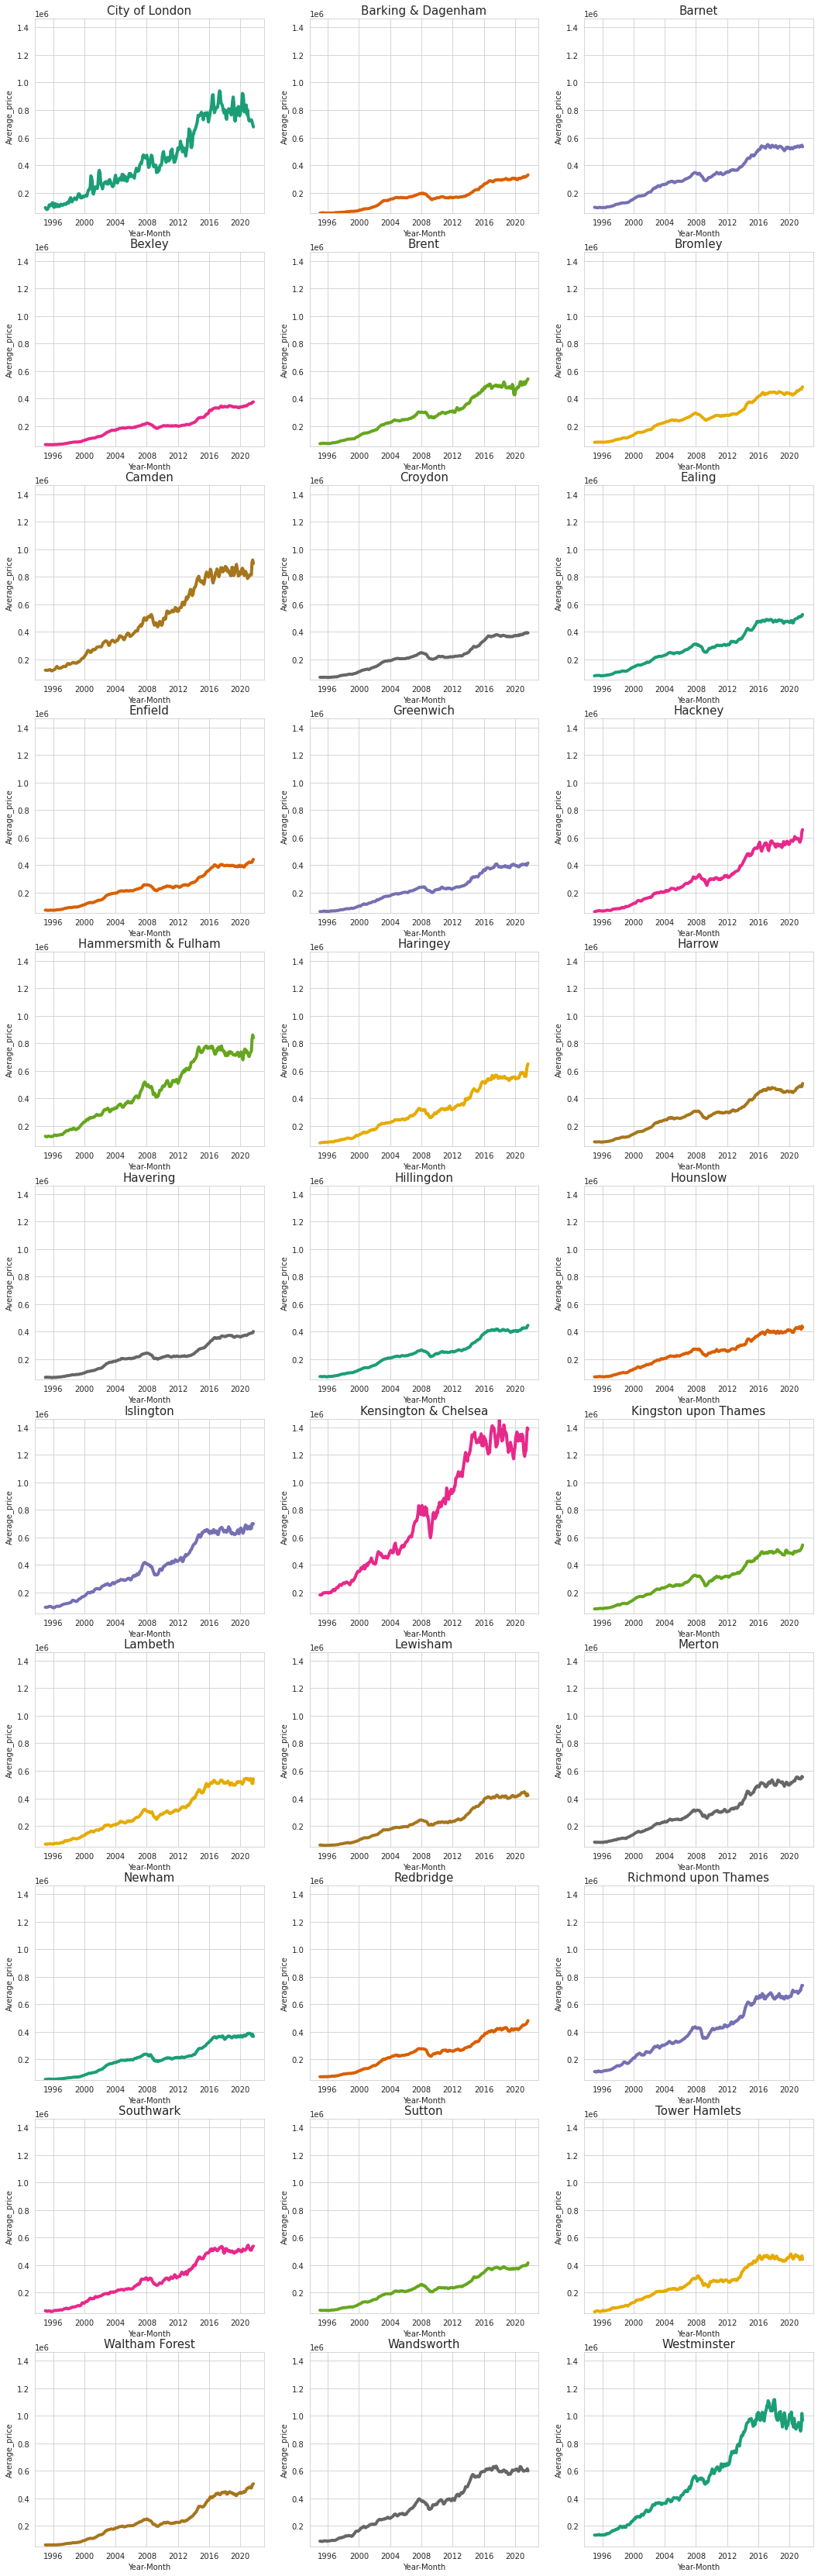

In [28]:
sns.set_style("whitegrid")
london_b = df.London_Borough.unique()
min_price = min(df['Average_price'])
max_price = max(df['Average_price'])
fig, axes = plt.subplots(len(london_b)//3, 3, figsize=(18, 60))
axes = axes.flatten()
cmap = plt.cm.Dark2
colors = cmap(np.arange(len(london_b)) % cmap.N)

for i, lb in enumerate(london_b):
    sns.lineplot(data=df[df['London_Borough'] == lb], x="Year-Month", y="Average_price", color=colors[i], linewidth=4, ax = axes[i])
    axes[i].set_title(lb, fontsize=15)
    axes[i].set_ylim(min_price, max_price)

Immediately, it can be observed that all 32 boroughs and the City of London have experienced growth over the past 26 years. Also, a clear drop is observed in 2009 for each area. Kensington & Chelsea appears to have the greatest overall growth in house prices, whereas Newham, Havering, and Croydon have the least.

Now, let's extract the year from the `Year-Month` variable in preparation for the next step - modeling.

In [29]:
#extracting the year
df['Year'] = df['Year-Month'].apply(lambda t: t.year)
df.tail()

,London_Borough,ID,Year-Month,Average_price,Year
10588,Sutton,E09000029,2021-09-01,415227.6650,2021
10589,Tower Hamlets,E09000030,2021-09-01,440846.7361,2021
10590,Waltham Forest,E09000031,2021-09-01,505389.1863,2021
10591,Wandsworth,E09000032,2021-09-01,599124.4127,2021
10592,Westminster,E09000033,2021-09-01,965766.3554,2021


## 4. Modeling

Now, that dataset is cleaned, transformed, and we've been able to grasp some understanding of it's trends through visuals. Now, it's time to begin answering our objective: **which five boroughs of London have seen the greatest increase in housing prices, on average, over the past two decades?**

In [30]:
#calculate the mean house price for each year
dfg = df.groupby(by=['London_Borough', 'Year']).mean()
dfg.sample(10)

,,Average_price
London_Borough,Year,
Westminster,2009,5.320970e+05
Tower Hamlets,2008,2.980022e+05
Richmond upon Thames,1999,1.817723e+05
Redbridge,2014,3.041625e+05
Kensington & Chelsea,2013,1.126573e+06
Harrow,2017,4.707634e+05
Haringey,2008,3.033961e+05
Havering,2012,2.216021e+05
Croydon,2005,2.044073e+05


In [31]:
dfg = dfg.reset_index()
dfg.head()

,London_Borough,Year,Average_price
0,Barking & Dagenham,1995,51817.969390
1,Barking & Dagenham,1996,51718.192690
2,Barking & Dagenham,1997,55974.262309
3,Barking & Dagenham,1998,60285.821083
4,Barking & Dagenham,1999,65320.934441


Now, let's calculate the growth rate in price from 1995 to 2021 for each district by doing the following:

1. Take a filter of dfg, specifically where this filter constrains the `London_Borough`, as an argument.
2. Get the `Average_price` for each Borough, for the years 1995 and 2021.
4. Calculate the percentage increase in price by taking the "increase ÷ original number × 100". In this case, the "increase" is the `Average_price` of 2021 divided by the `Average_price` of 1995 and the "original number" is the `Average_price` of 1995.
5. Then return the rates and 2021 average housing price by borough.

In [32]:
unique_district_list = list(dfg.London_Borough.unique())
list_of_rate = []
list_of_price2021 = []

for x in unique_district_list:
    #conditions
    is_district = dfg['London_Borough'] == x
    is_1995 = dfg['Year'] == 1995
    is_2021 = dfg['Year'] == 2021
    #get the value
    price_1995 = dfg[is_1995 & is_district]['Average_price'].values
    price_2021 = dfg[is_2021 & is_district]['Average_price'].values
    growth_rate = (price_2021 - price_1995)/price_1995*100
    list_of_rate.append(round(growth_rate[0],2))
    list_of_price2021.append(round(price_2021[0],2))

print(list_of_rate)
print(list_of_price2021)

[512.13, 485.0, 466.94, 611.88, 467.45, 598.7, 625.14, 464.18, 527.77, 488.66, 539.85, 807.43, 519.6, 638.75, 483.46, 469.99, 484.12, 487.48, 611.93, 565.46, 519.36, 679.4, 638.31, 580.75, 596.46, 529.77, 540.21, 713.82, 467.37, 613.35, 691.41, 577.92, 603.25]
[317192.41, 536987.43, 364494.94, 519883.94, 465127.33, 841007.56, 718503.43, 388851.7, 509867.63, 423740.37, 405602.47, 599128.2, 763579.19, 591583.54, 487304.39, 389194.33, 430818.8, 428514.58, 680285.85, 1283384.2, 513070.38, 530812.49, 434728.65, 548007.8, 380088.3, 457088.12, 703537.61, 522960.11, 398813.6, 454065.53, 484978.72, 602186.46, 940164.31]


In [33]:
#dataframe with boroughs and their growth rates
comparison_table = pd.DataFrame()
comparison_table['Borough'] = unique_district_list
comparison_table['Price increase rate'] = list_of_rate
comparison_table['Average price 2021'] = list_of_price2021
print(comparison_table.sort_values('Price increase rate', ascending=False)) 

                 Borough  Price increase rate  Average price 2021
11               Hackney               807.43           599128.20
27             Southwark               713.82           522960.11
30        Waltham Forest               691.41           484978.72
21               Lambeth               679.40           530812.49
13              Haringey               638.75           591583.54
22              Lewisham               638.31           434728.65
6         City of London               625.14           718503.43
29         Tower Hamlets               613.35           454065.53
18             Islington               611.93           680285.85
3                  Brent               611.88           519883.94
32           Westminster               603.25           940164.31
5                 Camden               598.70           841007.56
24                Newham               596.46           380088.30
23                Merton               580.75           548007.80
31        

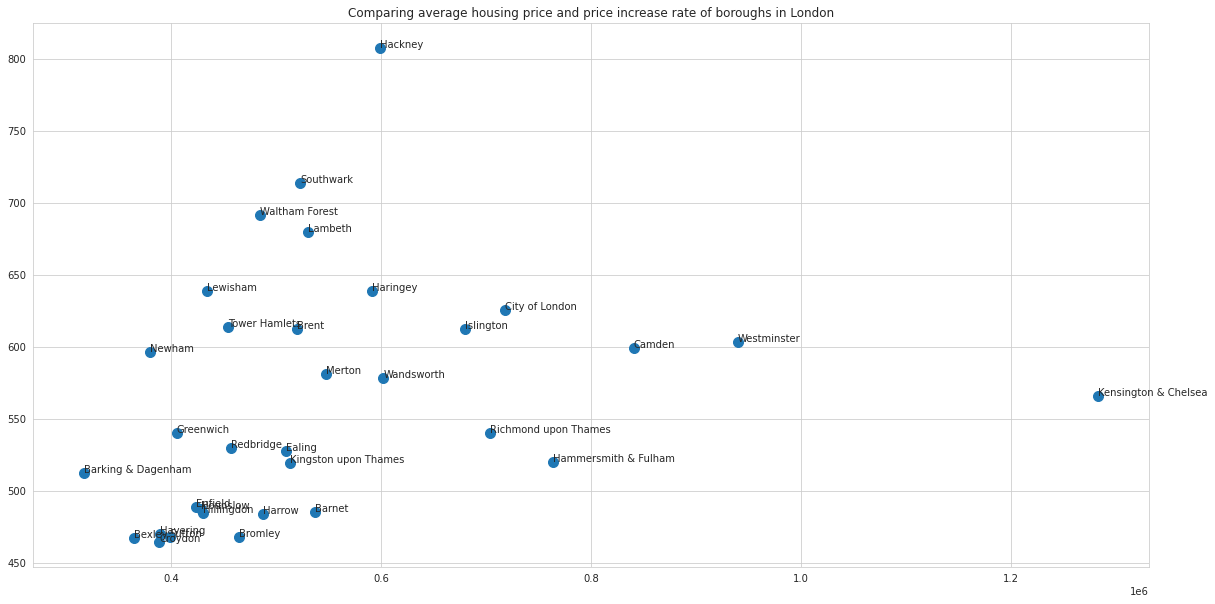

In [34]:
#visualization of the table
X = list_of_price2021
Y = list_of_rate
annotations = unique_district_list
plt.figure(figsize=(20,10))
plt.scatter(X,Y, s = 100)
plt.xlabel = 'Average price in 2021'
plt.ylabel = 'Price increase rate 1995 - 2021'
plt.title('Comparing average housing price and price increase rate of boroughs in London')

for i, label in enumerate(annotations):
    plt.annotate(label, (X[i], Y[i]))

In [35]:
top15_prices = comparison_table.sort_values(by='Average price 2021',ascending=False).head(15)
print(top15_prices)

                 Borough  Price increase rate  Average price 2021
19  Kensington & Chelsea               565.46          1283384.20
32           Westminster               603.25           940164.31
5                 Camden               598.70           841007.56
12  Hammersmith & Fulham               519.60           763579.19
6         City of London               625.14           718503.43
26  Richmond upon Thames               540.21           703537.61
18             Islington               611.93           680285.85
31            Wandsworth               577.92           602186.46
11               Hackney               807.43           599128.20
13              Haringey               638.75           591583.54
23                Merton               580.75           548007.80
1                 Barnet               485.00           536987.43
21               Lambeth               679.40           530812.49
27             Southwark               713.82           522960.11
3         

From the print out of `top15_prices` and the visualization above, we can see the borough `Kensington & Chelsea` doesn't have the highest price increase rate, but it does have the highest housing prices on average for 2021.

In [36]:
#sort in descending order and select the top 15 Boroughs
top15_rates = comparison_table.sort_values(by='Price increase rate',ascending=False).head(15)
print(top15_rates)

           Borough  Price increase rate  Average price 2021
11         Hackney               807.43           599128.20
27       Southwark               713.82           522960.11
30  Waltham Forest               691.41           484978.72
21         Lambeth               679.40           530812.49
13        Haringey               638.75           591583.54
22        Lewisham               638.31           434728.65
6   City of London               625.14           718503.43
29   Tower Hamlets               613.35           454065.53
18       Islington               611.93           680285.85
3            Brent               611.88           519883.94
32     Westminster               603.25           940164.31
5           Camden               598.70           841007.56
24          Newham               596.46           380088.30
23          Merton               580.75           548007.80
31      Wandsworth               577.92           602186.46


## 5. Summary
**Which five boroughs of London have seen the greatest increase in housing prices, on average, over the last two decades?** From the print out of the `top15_rates` the borough `Hackney` has experienced the most significant increase in housing prices, on average at 807.43% from January 1995 to September 2021. Followed by Southwark at 713.82%, Waltham Forest at 691.41%, Lambeth at 679.40%, and Haringey at 638.31% for the top 5 boroughs by `Price increase rate`. 